In [1036]:
# %% General
import warnings
warnings.filterwarnings ( "ignore" )
import os
from time import time
from datetime import datetime,timedelta  #time,
import matplotlib.pyplot as plt
import multiprocess as mp
from IPython.display import display


# Scientific and data
import json
import numpy as np
from tqdm import tqdm
import pandas as pd
import  xarray as xr
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.interpolate import griddata
from functools import partial
eps = np.finfo(np.float).eps
from scipy.stats import multivariate_normal

# pytorch
import torch , torchvision
import torch.utils.data
import torch.nn as nn
from torch import functional as F
from torch import Tensor
torch.manual_seed(8318)
from sklearn.model_selection import train_test_split


# Local modules
import  global_settings as gs
import data_loader as dl
import preprocessing as prep
from utils import create_and_configer_logger
from miscLidar import calc_extiction_klett
# %%

In [ ]:
# %%
def get_random_sample_grid(nx,ny,orig_x, orig_y,std_ratio=.125):
	delta_x = (orig_x[-1]-orig_x[0])/nx
	delta_y = (orig_y[-1]-orig_y[0])/ny

	# generate a new grid (points are set to be in the middle of each patch)
	center_x = .5*delta_x + (np.arange(nx)*delta_x).astype(int).reshape((1,nx)).repeat(ny,axis=0) + orig_x[0]
	center_y = .5*delta_y + (np.arange(ny)*delta_y).astype(int).reshape((ny,1)).repeat(nx,axis=1) + orig_y[0]

	# set random distances from centers of the new grid
	dx = (std_ratio*delta_x*np.random.randn(nx,ny)).astype(int).T
	dy = (std_ratio*delta_y*np.random.randn(nx,ny)).astype(int).T

	# set random point in each patch of the new grid
	points_x = center_x + dx
	points_y = center_y + dy

	new_grid = {'x': center_x.flatten(),'y':center_y.flatten()}
	sample_points = {'x': points_x.flatten(),'y':points_y.flatten()}
	return  new_grid,sample_points

def get_random_cov_mat(lbound_x = .5 , lbound_y=.1):
	# generating covariance matrix with higher x diagonal of gaussian
	# set : lbound_x< std_x <= 1
	std_x = 1 - lbound_x*np.random.rand()
	# set : lbound_y < std_y <= std_x
	std_y = std_x - (std_x-lbound_y)*np.random.rand()
	# %%
	# generate random correlation [-1,1]
	# this is to make sure that the covariance matrix is PSD : std_x*std_y - std_xy*std_xy >= 0
	rho = -1 + 2*np.random.rand()
	std_xy = rho*std_y*std_x
	cov = np.array([[std_x,std_xy],[std_xy,std_y]])
	return cov

def make_interpolated_image(nsamples,im):
    """Make an interpolated image from a random selection of pixels.

    Take nsamples random pixels from im and reconstruct the image using
    scipy.interpolate.griddata.

    """
    nx, ny = im.shape[1], im.shape[0]
    X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))
    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = griddata((iy, ix), samples, (Y, X),method = 'nearest',fill_value = 0)
    return int_im

def create_gaussians_level(grid,nx,ny,grid_x,grid_y,std_ratio=.125,choose_ratio = 1.0,
                           cov_size = 1E-5, cov_r_lbounds=[.8,.1]):

	# create centers of Gaussians:
	new_grid,sample_points = get_random_sample_grid(nx,ny,grid_x,grid_y,std_ratio)
	if choose_ratio<1.0:
		center_x, _, center_y, _ = train_test_split(sample_points['x'],sample_points['y'],
		                                                    train_size = choose_ratio,shuffle = True)
	else:
		center_x = sample_points['x']
		center_y = sample_points['y']

	# Create covariance to each gaussian and adding each
	grid_ratio = 1
	Z_level = np.zeros((grid.shape[0],grid.shape[1]))
	for x0,y0 in zip(center_x,center_y):
		cov = cov_size*get_random_cov_mat(lbound_x = cov_r_lbounds[0] , lbound_y=cov_r_lbounds[1])
		rv = multivariate_normal((x0,y0), cov)
		Z_level += grid_ratio*rv.pdf(grid)
	# normalizing:
	Z_level = (Z_level - Z_level.min())/(Z_level.max() - Z_level.min())
	return Z_level

def angstrom(tau_1,tau_2, lambda_1,lambda_2):
	"""
	calculates angstrom exponent
	:param tau_1: AOD Aerosol optical depth at wavelength lambda_1
	:param tau_2: AOD Aerosol optical depth at wavelength lambda_2
	:param lambda_1: wavelength lambda_1 , lambda_1<lambda_2 (e.g. 355 nm)
	:param lambda_2: wavelength lambda_2 , lambda_1<lambda_2 (e.g. 532 nm)
	:return: angstrom exponent A_1,2
	"""
	return -np.log(tau_1/tau_2)/np.log(lambda_1/lambda_2)

def get_sub_sample_level (level, source_indexes, target_indexes):
	z_samples = level[:,source_indexes]
	df_sigma= pd.DataFrame(z_samples,columns = target_indexes)
	interp_sigma_df = (df_sigma.T.resample( '30S' ).interpolate ( method = 'linear' )).T
	sampled_interp = interp_sigma_df.values
	sampled_interp=(sampled_interp-sampled_interp.min())/(sampled_interp.max()-sampled_interp.min())
	return sampled_interp

def normalize(x,max_value=1):
	return max_value*(x-x.min())/(x.max()-x.min())
# %%

In [1073]:
total_time_bins = 2880
dr = 7.4714e-3
top_height = 10 #km
total_height_bins = np.int(top_height/dr)
x = np.arange(total_time_bins)
y = np.arange(total_height_bins)

#X, Y = np.mgrid[0:total_time_bins:1, 0:total_height_bins:1]
#grid = np.dstack((X, Y))
#grid.shape
# %%
X, Y = np.meshgrid(x,y,indexing = 'xy')
grid = np.dstack((X, Y))
grid.shape

(1338, 2880, 2)

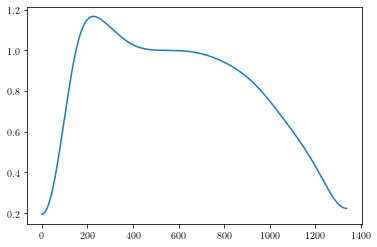

In [1506]:
t = np.array([0,0.025,0.05,0.1,.3,.5,.6,.7,.8,.9,1.0])*np.float(total_height_bins)
ratios = np.array([.0,0.05,.1,1.3,1,1,.95,0.85,0.65,.45,0.1])
t_interp = np.arange(start = 1,stop=total_height_bins+1,step=1)
ratio_interp= np.interp(t_interp,t,ratios)
plt.figure()
plt.plot(t_interp,gaussian_filter1d(ratio_interp, sigma=60))
plt.show()


In [881]:
nx =5
ny = 1
grid_ratio = 1.0
cov_size =1E+6
choose_ratio = .95
std_ratio = .25
cov_r_lbounds=[.8,.1]
Z_level0 = create_gaussians_level(grid,nx,ny,x,y[ 0:int(0.5*total_height_bins)],std_ratio,
                                  choose_ratio,cov_size,cov_r_lbounds)

plt.figure()
im = plt.imshow(Z_level0,cmap = 'turbo')
plt.colorbar(im)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

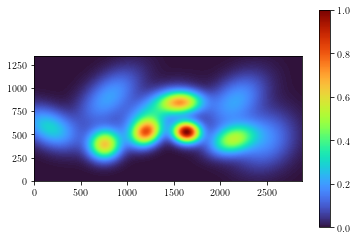

In [893]:
nx = 6
ny = 2
grid_ratio = 1.0
cov_size = 5*1E+4
choose_ratio = .9
std_ratio = .15
cov_r_lbounds=[.8,.1]
Z_level1 = create_gaussians_level(grid,nx,ny,x,y[ int(0.2*total_height_bins):int(0.8*total_height_bins)],std_ratio,
                                  choose_ratio,cov_size,cov_r_lbounds)

plt.figure()
im = plt.imshow(Z_level1,cmap='turbo')
plt.colorbar(im)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

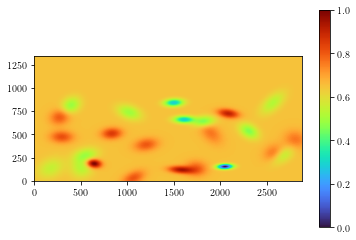

In [904]:
nx = 9
ny = 1
new_grid,sample_points = get_random_sample_grid(nx,ny,x, y[int(0*total_height_bins):int(.3*total_height_bins)],
                                                std_ratio=.25)
center_x = sample_points['x']
center_y = sample_points['y']

nx = 8
ny = 1
new_grid,sample_points = get_random_sample_grid(nx,ny,x,  y[int(.2*total_height_bins):int(.5*total_height_bins)],
                                                std_ratio=.25)
center_x1 = sample_points['x']
center_y1 = sample_points['y']

nx = 7
ny = 1
new_grid,sample_points = get_random_sample_grid(nx,ny,x, y[int(.4*total_height_bins):int(0.7*total_height_bins)],
                                                std_ratio=.25)
center_x2 = sample_points['x']
center_y2= sample_points['y']

# %%
center_x_split_1, center_x_split_2, center_y_split_1, center_y_split_2 =\
	train_test_split(np.concatenate((center_x, center_x1,center_x2),axis = 0),
	                 np.concatenate((center_y, center_y1,center_y2),axis = 0),
	                 train_size = .5)

grid_cov_size = 1E+4
Z_level2 = np.zeros((grid.shape[0],grid.shape[1]))
for x0,y0 in zip(center_x_split_1,center_y_split_1):
	cov = grid_cov_size*get_random_cov_mat(lbound_x = .7 , lbound_y=.01)
	rv = multivariate_normal((x0,y0), cov)
	r = 1#ratio_interp[int(y0)]
	Z_level2 += r*grid_ratio*rv.pdf(grid)
for x0,y0 in zip(center_x_split_2,center_y_split_2):
	cov = grid_cov_size*get_random_cov_mat(lbound_x = .7 , lbound_y=.01)
	rv = multivariate_normal((x0,y0), cov)
	r = -1 #ratio_interp[int(y0)]
	Z_level2 += r*grid_ratio*rv.pdf(grid)

Z_level2 = (Z_level2 -Z_level2.min())/(Z_level2.max()-Z_level2.min())
plt.figure()
im = plt.imshow(Z_level2,cmap = 'turbo')
plt.colorbar(im)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

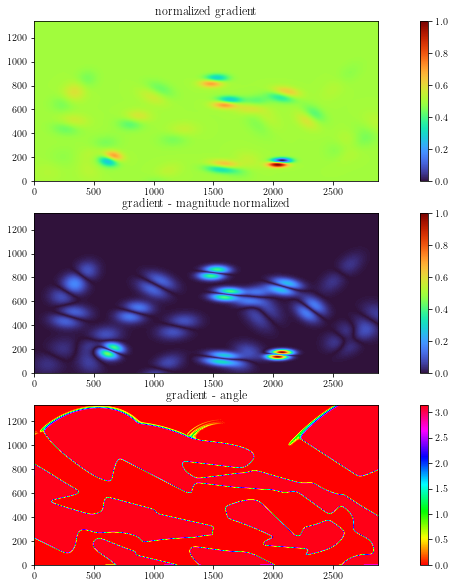

In [905]:
import cv2 as cv
from scipy import signal
g_filter = np.array([[0 , -1, 0],
                     [-1, 0 , 1],
                     [0 , 1 , 0]])
grad = signal.convolve2d(Z_level2, g_filter, boundary='symm', mode='same')
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
ax = axes.ravel()
ax_i = ax[0]
grad_norm = (grad-grad.min())/(grad.max()-grad.min())
im = ax_i.imshow(grad_norm, cmap='turbo')
plt.colorbar(im, ax=ax_i)
ax_i.set_aspect('equal')
ax_i.invert_yaxis()
ax_i.set_title('normalized gradient')

ax_i= ax[1]
grad_amplitude = np.absolute(grad)
grad_norm_amplitude= (grad_amplitude-grad_amplitude.min())/(grad_amplitude.max()-grad_amplitude.min())
im = ax_i.imshow(grad_norm_amplitude, cmap='turbo')
plt.colorbar(im, ax=ax_i)
ax_i.set_aspect('equal')
ax_i.invert_yaxis()
ax_i.set_title('gradient - magnitude normalized')

ax_i= ax[2]
im = ax_i.imshow(np.angle(grad), cmap='hsv')
plt.colorbar(im, ax=ax_i)
ax_i.set_aspect('equal')
ax_i.invert_yaxis()
ax_i.set_title('gradient - angle')
plt.show()

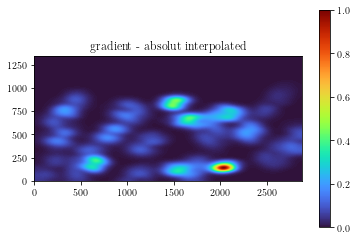

In [932]:
nsamples= int(total_height_bins*total_time_bins *.0005)
interp_features = make_interpolated_image(nsamples,grad_norm_amplitude)
blur_features= gaussian_filter(interp_features,sigma=(21,61))
blur_features = (blur_features-blur_features.min())/(blur_features.max()-blur_features.min())
plt.figure()
im = plt.imshow(blur_features, cmap='turbo')
plt.colorbar(im)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.title('gradient - absolut interpolated')
plt.show()

In [929]:
indexes= np.round(np.linspace(0,720,97)).astype(int)
target_indexes = [ i*30 for i in range(97)]
target_indexes[-1]-=1
start_t = datetime(2017,9,1,0,0)
end_t = start_t+timedelta(hours = 24)-timedelta(seconds = 30)
target_time_index = pd.date_range(start = start_t,end = end_t,freq = '30S')
tt_index = target_time_index[target_indexes]

## The 3 levels of aerosol density

In [1101]:
# %%
source_indexes = indexes
sampled_level0_interp  = get_sub_sample_level (Z_level0, source_indexes, tt_index)
# %%
source_indexes = indexes+720*1-1
sampled_level1_interp  = get_sub_sample_level (Z_level1, source_indexes, tt_index)
# %%
source_indexes = indexes+720*1-1
sampled_level2_interp  = get_sub_sample_level (blur_features, source_indexes, tt_index)

In [1092]:
heights = np.linspace ( 0 , top_height , total_height_bins )
levels = []
for indl,level in enumerate([sampled_level0_interp,sampled_level1_interp,sampled_level2_interp]):
	ds_level = xr.Dataset (
	    data_vars = {'density' : (('Height','Time') , level) ,
                     'level' : ('Level' , [indl])
                     } ,
        coords = {'Height': heights,
                  'Time' : target_time_index.tolist(),
                  'Level' : [indl]
                  })
	levels.append(ds_level)
ds_density = xr.concat(levels,dim='Level')
ds_density.Height.attrs = {'units':'km'}

Coordinates:
  * Height   (Height) float64 0.0 0.007479 0.01496 0.02244 ... 9.985 9.993 10.0
  * Time     (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30
  * Level    (Level) int64 0 1 2

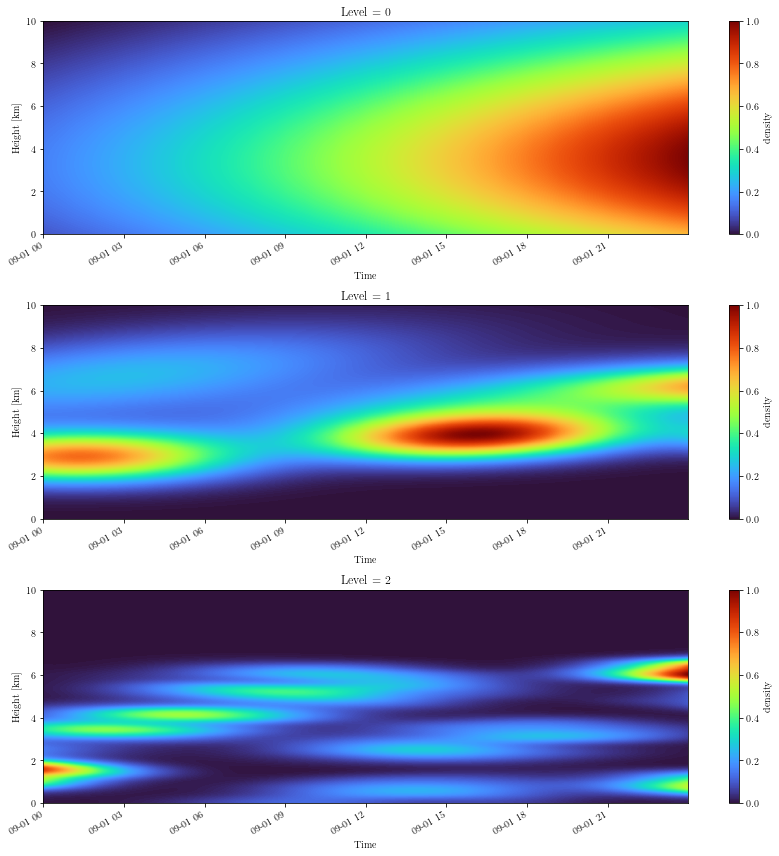

In [1099]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,12))
for l,ax in zip(ds_density.Level,axes.ravel()):
	ds_density.density.sel(Level = l).plot(cmap='turbo', ax=ax)
plt.tight_layout()
plt.show()

## Profiles at different times

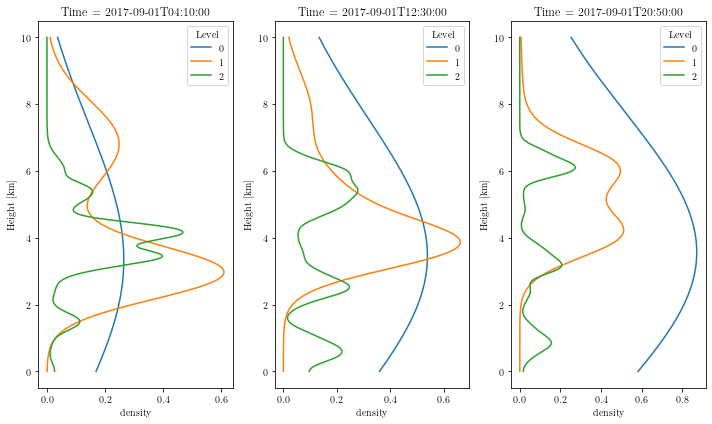

In [1109]:
t_index = [500,1500,2500]
times = [ds_density.Time[ind].values for ind in t_index]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
for t, ax in zip(times,axes.ravel()):
	ds_density.density.sel(Time = t).plot.line(ax= ax,y='Height')
plt.tight_layout()
plt.show()


## Merged density level
#### Built as a linear combination of the levels above

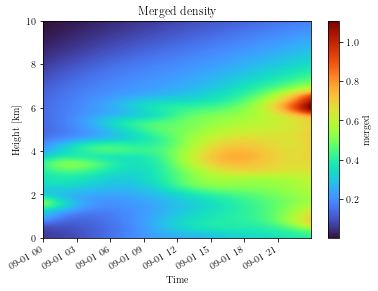

In [1549]:
atmosphere_ds = ds_density.assign({'weights':('Level',[.6,.3,.4])})
merged = xr.zeros_like(ds_density.density[0])
for l in ds_density.Level:
	merged += ds_density.density.sel(Level=l)*atmosphere_ds.weights.sel(Level=l)
atmosphere_ds =  atmosphere_ds.assign(merged = merged)
atmosphere_ds.merged.attrs = {'info':'Merged density'}
atmosphere_ds.merged.plot(cmap='turbo')
plt.title(atmosphere_ds.merged.attrs['info'])
plt.show()

Create empty $\beta$ and $\sigma$ densities

In [1551]:
atmosphere_ds = atmosphere_ds.assign_coords(Wavelength=[355,532,1064])
sigma = xr.zeros_like(merged).reset_coords(drop = True).expand_dims(dim ={'Wavelength':[355,532,1064]})
sigma.name ='sigma'
sigma.attrs={'long_name':r"$\sigma$",'units':r"$1/km$"}
atmosphere_ds =atmosphere_ds.assign(sigma=sigma.copy(deep=True))
beta = xr.zeros_like(sigma)
beta.name ='beta'
beta.attrs={'long_name':r"$\beta",'units':r"$1/sr \cdot km$"}
atmosphere_ds =atmosphere_ds.assign(beta=beta.copy(deep=True))
atmosphere_ds =atmosphere_ds.assign({'ratio':('Height',ratio_interp)})

## Creating $\sigma_{532}$
#### To create the aerosol, the density is:
1. Normalized
2. Corrected according to ratio above
3. multiplied with a typical $\sigma_{aer,532}$, e.g. $\sigma_{max}=0.025[1/km]$

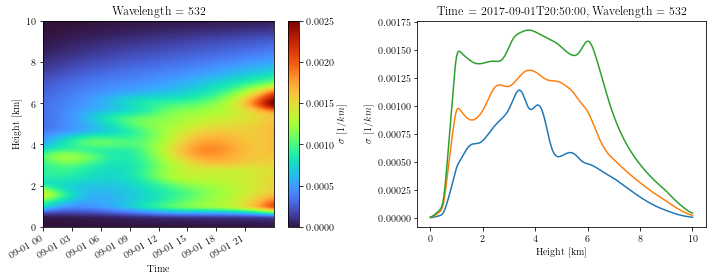

In [1747]:
max_val =.0025
sigma_ratio = xr.apply_ufunc(lambda x,r: gaussian_filter(r*x,sigma = (9,5)),
                         atmosphere_ds.merged,atmosphere_ds.ratio,keep_attrs = False)
atmosphere_ds.sigma.loc[dict(Wavelength=532)] = xr.apply_ufunc(lambda x: normalize(x,max_val),
                         sigma_ratio.copy(deep=True),keep_attrs = False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax = axes.ravel()
atmosphere_ds.sigma.sel(Wavelength=532).plot(cmap='turbo',ax =ax[0])

for t in times:
	atmosphere_ds.sigma.sel(Wavelength=532,Time=t).plot(ax=ax[1])
plt.tight_layout()
plt.show()

## Calculate Aearosol Optical Depth (AOD)
## $\tau_{aer,\lambda} = \int \sigma_{aer,\lambda} (r) dr\;\; \forall \, r \leq r_{ref} $

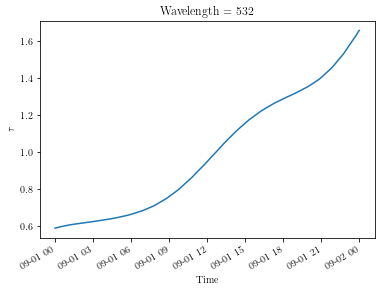

In [1748]:
tau_g = atmosphere_ds.sigma.sel(Wavelength=532).sum(dim='Height')
tau_g.name=r'$\tau$'
tau_g.plot()
plt.show()

## Angstrom Exponent
### To convert $\sigma_{aer}$ from $532[nm]$ to $355[nm]$ and $1064[nm]$
### Typical values of angstrom exponent are from 20170901_20170930_haifa_ang.nc

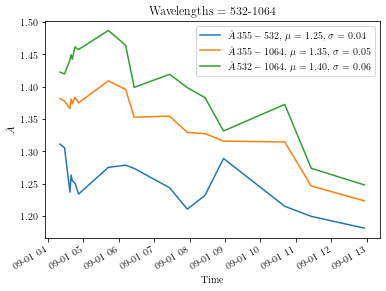

In [1614]:
nc_name = '20170901_20170930_haifa_ang.nc'
folder_name ='D:\data_haifa\AERONET'
ds_ang = prep.load_dataset(os.path.join(folder_name,nc_name))

start_day = datetime(2017,9,1)
t_slice =slice(start_day,start_day+timedelta(days =1))
means = []
for wavelengths in ds_ang.Wavelengths:
	angstrom_mean = ds_ang.angstrom.sel(Wavelengths = wavelengths ,Time=t_slice).mean().item()
	angstrom_std = ds_ang.angstrom.sel(Wavelengths = wavelengths ,Time=t_slice).std().item()

	textstr = ' '.join((
	r'$\mu=%.2f$, ' % (angstrom_mean, ),
	r'$\sigma=%.2f$' % (angstrom_std, )))
	ds_ang.angstrom.sel(Wavelengths = wavelengths ,Time=t_slice).\
		plot(x='Time',label =fr"$ \AA \, {wavelengths.item()}$, "+textstr)
	means.append(angstrom_mean)
plt.legend()
plt.show()

Estimate AOD of $\lambda=1064nm$ and  $\lambda=355nm$

$\tau_{1064} = \frac{\tau_{532}}{(532/1064)^{-A_{532,1064}}}$

$\tau_{355} =\tau_{532} \cdot (355/532)^{-A_{355,532}} $

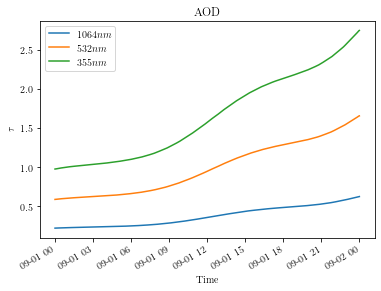

In [1749]:
tau_ir = (tau_g/((532/1064)**(-means[2]))).copy(deep=True)
tau_ir['Wavelength'] = 1064
tau_uv = (tau_g*((355/532)**(-means[0]))).copy(deep=True)
tau_uv['Wavelength'] = 355
tau_ir.plot(label=r'$1064nm$')
tau_g.plot(label=r'$532nm$')
tau_uv.plot(label=r'$355nm$')
plt.title('AOD')
plt.legend()
plt.show()

Normalizing the original density of sigma per time

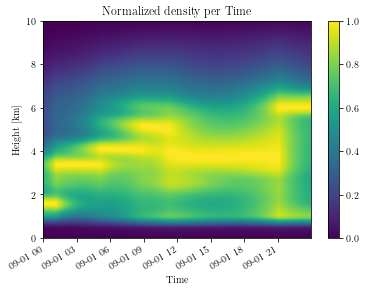

In [1750]:
sigma_normalized = xr.apply_ufunc(lambda x: normalize(x),sigma_ratio, keep_attrs = True).copy(deep=True)
for t in sigma_normalized.Time:
	sigma_t = sigma_normalized.sel(Time=t).copy(deep=True)
	sigma_t = xr.apply_ufunc(lambda x: normalize(x),sigma_t)
	sigma_normalized.loc[dict(Time=t)] = sigma_t

sigma_normalized.plot()
plt.title('Normalized density per Time')
plt.show()

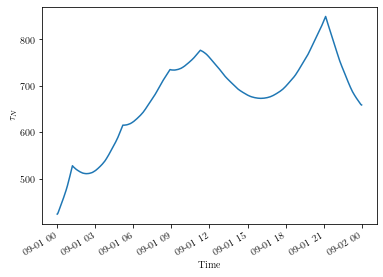

In [1751]:
tau_normalized = sigma_normalized.sum(dim='Height')
tau_normalized.name=r'$\tau_N$'
plt.title('Normalized AOD')
tau_normalized.plot()
plt.show()

convert $\sigma_{1064}$

### $\sigma_{1064}^{max}(t) = \frac{\tau_{1064}(t)}{\tau_N(t)}, \;\forall\, t \in Time_{day} $

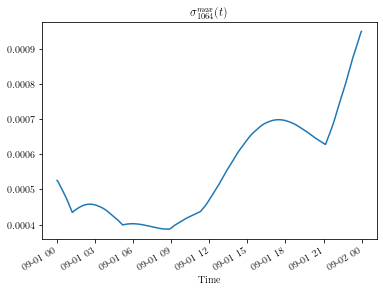

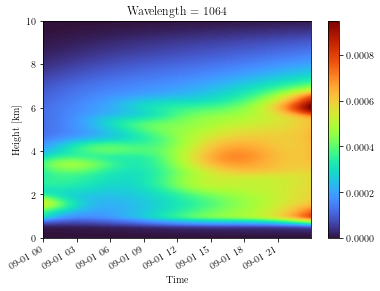

In [1752]:
sigma_max = tau_ir/tau_normalized
sigma_max.plot()
plt.title(r'$\sigma^{max}_{1064}(t) $')
plt.show()

sigma_ir = sigma_normalized*sigma_max
sigma_ir.plot(cmap='turbo')
plt.show()

convert $\sigma_{1064}$

### $\sigma_{355}^{max}(t) = \frac{\tau_{355}(t)}{\tau_N(t)}, \;\forall\, t \in Time_{day} $

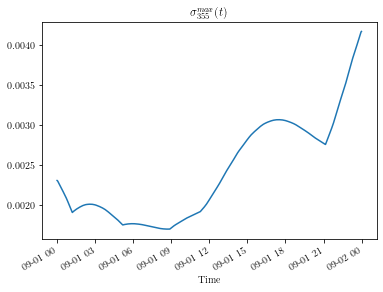

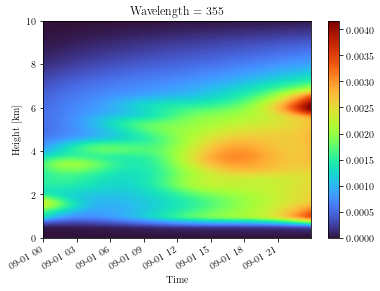

In [1753]:
sigma_max = tau_uv/tau_normalized
sigma_max.plot()
plt.title(r'$\sigma^{max}_{355}(t) $')
plt.show()

sigma_uv = sigma_normalized*sigma_max
sigma_uv.plot(cmap='turbo')
plt.show()

## Extinction profiles of $\sigma_{aer}$ at different times

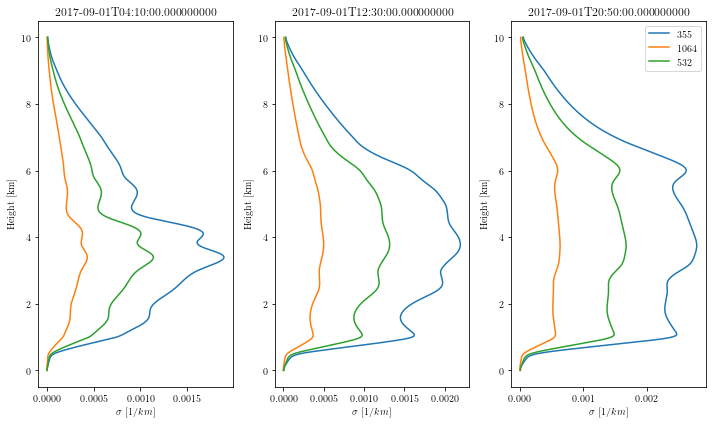

In [1754]:
t_index = [500,1500,2500]
times = [ds_density.Time[ind].values for ind in t_index]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
for t, ax in zip(times,axes.ravel()):
	sigma_uv.sel(Time = t).plot.line(ax= ax,y='Height',label=sigma_uv.Wavelength.item())
	sigma_ir.sel(Time = t).plot.line(ax= ax,y='Height',label=sigma_ir.Wavelength.item())
	atmosphere_ds.sigma.sel(Time = t,Wavelength=532).plot.line(ax= ax,y='Height',label=r'$532$')

	ax.set_title(t)
plt.legend()
plt.tight_layout()
plt.show()

## Calculate $\beta_{aer}$ assuming the lidar ratio $LR=60[sr]$

In [1761]:
LR =60
beta_uv = sigma_uv/LR
beta_uv.attrs = {'long_name':r'$\beta$','units':r'$1/km \cdot sr$'}
beta_ir = sigma_ir/LR
beta_ir.attrs = {'long_name':r'$\beta$','units':r'$1/km \cdot sr$'}
beta_g = atmosphere_ds.sigma.sel(Wavelength=532)/LR
beta_g.attrs = {'long_name':r'$\beta$','units':r'$1/km \cdot sr$'}
beta_g

<xarray.DataArray 'sigma' (Height: 1338, Time: 2880)>
array([[1.78850764e-08, 1.78906960e-08, 1.79017170e-08, ...,
        1.82061442e-07, 1.82086649e-07, 1.82099502e-07],
       [1.82308045e-08, 1.82364886e-08, 1.82476362e-08, ...,
        1.84350924e-07, 1.84376451e-07, 1.84389467e-07],
       [1.89184444e-08, 1.89242568e-08, 1.89356561e-08, ...,
        1.88904005e-07, 1.88930169e-07, 1.88943510e-07],
       ...,
       [2.57424844e-10, 2.92338929e-10, 3.60811516e-10, ...,
        8.67072852e-07, 8.67189223e-07, 8.67248560e-07],
       [8.60331537e-11, 1.20788787e-10, 1.88950624e-10, ...,
        8.63137715e-07, 8.63253578e-07, 8.63312656e-07],
       [0.00000000e+00, 3.46759555e-11, 1.02681530e-10, ...,
        8.61158764e-07, 8.61274370e-07, 8.61333318e-07]])
Coordinates:
  * Height      (Height) float64 0.0 0.007479 0.01496 ... 9.985 9.993 10.0
  * Time        (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30
    Wavelength  int32 532
Attributes:
    long_name:  $\beta$
    units:      $1/km \cdot sr$

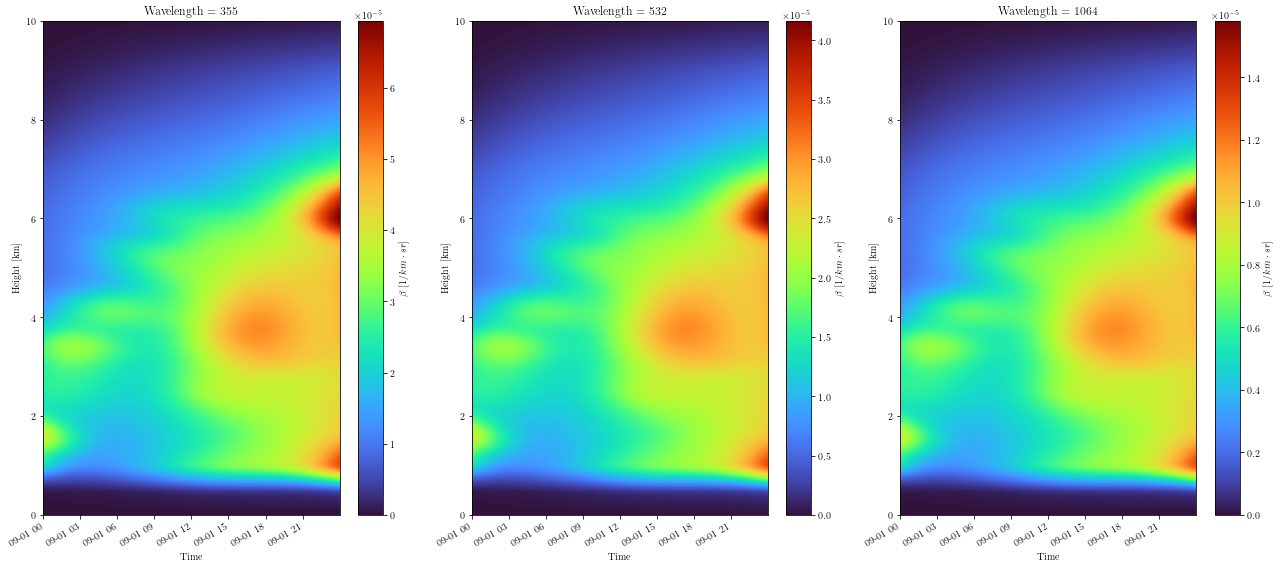

In [1763]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,8))
ax = axes.ravel()
beta_uv.plot(ax= ax[0],cmap='turbo')
beta_ir.plot(ax= ax[2],cmap='turbo')
beta_g.plot(ax= ax[1],cmap='turbo')
plt.tight_layout()
plt.show()

## Adding molecular profiles
### $\beta = \beta_{aer}+\beta_{mol}$
### $\sigma = \sigma_{aer}+\sigma_{mol}$
### The molecular profiles were calculated from radiosondes measurments from NOA
> Loading: 2017_09_01_Haifa_molecular.nc
> TODO: Add the missing heights values to the aerosol profiles

In [1769]:
nc_name = r'2017_09_01_Haifa_molecular.nc'
folder_name = r'D:\data_haifa\DATA FROM TROPOS\molecular_dataset\2017\09'
ds_mol = prep.load_dataset(os.path.join(folder_name,nc_name))

In [1770]:
#TODO: Add the missing heights values to the aerosol profiles
ds_mol.beta.sel(Wavelength=532)#+beta_g#).plot(cmap='turbo')
#plt.show()

<xarray.DataArray 'beta' (Height: 3000, Time: 2880)>
array([[1.43865075e-03, 1.43864848e-03, 1.43864621e-03, ...,
        1.43140521e-03, 1.43140680e-03, 1.43140839e-03],
       [1.43779095e-03, 1.43778866e-03, 1.43778637e-03, ...,
        1.43051648e-03, 1.43051798e-03, 1.43051949e-03],
       [1.43693086e-03, 1.43692856e-03, 1.43692625e-03, ...,
        1.42962737e-03, 1.42962878e-03, 1.42963019e-03],
       ...,
       [8.38533612e-05, 8.38536391e-05, 8.38539169e-05, ...,
        8.36838210e-05, 8.36833084e-05, 8.36827958e-05],
       [8.37674870e-05, 8.37677651e-05, 8.37680432e-05, ...,
        8.35973853e-05, 8.35968717e-05, 8.35963580e-05],
       [8.36816250e-05, 8.36819034e-05, 8.36821819e-05, ...,
        8.35109629e-05, 8.35104482e-05, 8.35099336e-05]])
Coordinates:
  * Height      (Height) float64 0.3088 0.3162 0.3237 ... 22.7 22.71 22.72
  * Time        (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30
    Wavelength  uint64 532
Attributes:
    long_name:  $\beta$
    units:      $1/km \cdot sr$
    info:       Molecular backscatter coefficient

In [1768]:
beta_g

<xarray.DataArray 'sigma' (Height: 1338, Time: 2880)>
array([[1.78850764e-08, 1.78906960e-08, 1.79017170e-08, ...,
        1.82061442e-07, 1.82086649e-07, 1.82099502e-07],
       [1.82308045e-08, 1.82364886e-08, 1.82476362e-08, ...,
        1.84350924e-07, 1.84376451e-07, 1.84389467e-07],
       [1.89184444e-08, 1.89242568e-08, 1.89356561e-08, ...,
        1.88904005e-07, 1.88930169e-07, 1.88943510e-07],
       ...,
       [2.57424844e-10, 2.92338929e-10, 3.60811516e-10, ...,
        8.67072852e-07, 8.67189223e-07, 8.67248560e-07],
       [8.60331537e-11, 1.20788787e-10, 1.88950624e-10, ...,
        8.63137715e-07, 8.63253578e-07, 8.63312656e-07],
       [0.00000000e+00, 3.46759555e-11, 1.02681530e-10, ...,
        8.61158764e-07, 8.61274370e-07, 8.61333318e-07]])
Coordinates:
  * Height      (Height) float64 0.0 0.007479 0.01496 ... 9.985 9.993 10.0
  * Time        (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30
    Wavelength  int32 532
Attributes:
    long_name:  $\beta$
    units:      $1/km \cdot sr$